In [1]:
import sys
import os
import random
import pickle
import numpy as np
from preprocessing import make_delayed
from preprocessing import downsample_word_vectors
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Add the root project folder to sys.path (so ridge_utils becomes importable)
project_root = os.path.abspath('..')  # moves up from 'code/'
sys.path.append(project_root)

In [2]:
# Load the raw_text.pkl file
path_to_data = '/ocean/projects/mth240012p/shared/data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)

print(type(raw_text))
print(len(raw_text)) # total 109 stories


<class 'dict'>
109


Before splitting the stories into train and test, since there are 8 more stories in the raw_text file than in the stories in subject 2 and 3, we exclude these stories since they cannot be used for both test or train. 

In [3]:
all_stories = set(raw_text.keys())
subj2_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject2') if f.endswith('.npy'))
subj3_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject3') if f.endswith('.npy'))
print(subj2_stories == subj3_stories) #fortunately, subject 2 and 3 has same stories
valid_stories = sorted(list(all_stories & subj2_stories & subj3_stories))
print(len(valid_stories)) 


True
101


Now we split test stories, train stories (3:7)

In [4]:
#we will just rename valid_stories as all_stories for the sake of simplicity.
all_stories = valid_stories
random.seed(42)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

print(f"Train stories: {len(train_stories)}")
print(f"Test stories: {len(test_stories)}")
train_stories.sort()
test_stories.sort()

Train stories: 70
Test stories: 31


In [5]:
#compute and append all words in train_stories
allwords = []
for story in train_stories:
    temp_text = raw_text[story].data
    allwords += temp_text

print(len(allwords))

#compute unique words in train_stories
unique_words = list(set(allwords))
len(unique_words)

137105


10360

**Word2Vec method**
Now we do the same process for Word2Vec method.

1. Make vectors for each word in train_stories
Create matrices for each stories. 

We use w2v pretrained model that gives a vector of length 300 for each word in train stories. 

In [6]:
# Load pre-trained Google News Word2Vec (300-dim)
# You need to download this separately
# Download from: https://code.google.com/archive/p/word2vec/

#unzip the gz file and put the bin file INSIDE the DATA folder
model_path = '../data/GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(model_path, binary=True)


First, we check if the W2V model includes all the unique words for all the words in train_stories.
We use unique_words that we defined earlier. 
We see below that about 5% of the words are not defined in w2v, but since 5% is negligible, we just put 0 vectors for the words that aren't defined in w2v model. 

In [7]:
in_model = [word for word in unique_words if word in w2v]
not_in_model = [word for word in unique_words if word not in w2v]
print(f"Percentage of words Not in w2v model: {len(not_in_model)/len(unique_words):.4f}")

Percentage of words Not in w2v model: 0.0535


In [8]:
#define function that returns matrix given word_list, model=w2v, 
#vector_size = 300 which is from the pretrained model

def embed_story_words(word_list, model, vector_size):
    embedded = []
    for word in word_list:
        if word in model:
            embedded.append(model[word])
        else:
            embedded.append(np.zeros(vector_size))  # unknown word
    return np.vstack(embedded)

In [9]:
vector_size = 300 #of pretrained model 
story_vectors_w2v = {} 
#Dictionary where key is story name and value is matrix, whose vectors correspond to each word in story

for story in train_stories:
    words = raw_text[story].data
    story_vectors_w2v[story] = embed_story_words(words, w2v, vector_size)

2. Downsample and Trim for matrices made by W2V model

In [10]:
#made dictionary whose keys are name of train story and values are raw_text[story]
wordseqs = {story: raw_text[story] for story in train_stories}
# we already defines wordseqs in BoW method.
downsampled_vectors_2 = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_w2v,
    wordseqs=wordseqs
)

In [11]:
trimmed_vectors_2 = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_2.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_2[story] = trimmed_matrix


3. Creating lagged versions

Since the current number of columns for each matrix ix 300, 
the new matrices will have 300*4=1200 columns.

In [12]:
delayed_vectors_2 = {}

for story, trimmed_matrix in trimmed_vectors_2.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_2[story] = X_lagged

# check for first trimmed,delayed matrix, which corresponds to first story
for key, value in delayed_vectors_2.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break

First key: adventuresinsayingyes
delayed matrix for first story is (391, 1200)


Now we make embeddings for test stories.

In [13]:
story_vectors_w2v_test = {}
for story in test_stories:
    words = raw_text[story].data
    story_vectors_w2v_test[story] = embed_story_words(words, w2v, vector_size)

wordseqs2 = {story: raw_text[story] for story in test_stories}
downsampled_vectors_2_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_w2v_test,
    wordseqs=wordseqs2
)

trimmed_vectors_2_test = {} #trimmed matrices for each test story 
for story, matrix in downsampled_vectors_2_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_2_test[story] = trimmed_matrix

delayed_vectors_2_test = {}
for story, trimmed_matrix in trimmed_vectors_2_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_2_test[story] = X_lagged

print(len(delayed_vectors_2_test))

31


In [14]:
import gc
del w2v
del raw_text
gc.collect()


0

PART 2

**Subject2**

In [15]:
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
import numpy as np
import logging
from ridge_utils.ridge import ridge_corr
from ridge_utils.utils import mult_diag
import random
from sklearn.model_selection import KFold

Now that we have made all the three train and test dictionaries, we will Y_test and Y_train for subject 2.

In [16]:
path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

In [17]:
#Test for w2v, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_2[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_2_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

2(1). First we fit ridge regression. 

Since we don't know the alphas(hyperparameters) yet, we try with alpha = 1 for all voxels. 

In [18]:
logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

In [19]:
#subject 2
num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)
#We can see that when alphas are poorly set, the mean CC across voxels are very low. 

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1454.498
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.004998043236055478


2(1). CV 

We use 5-fold CV to get best alphas for each voxel. 

We first splitted 70 training stories into 5 fold CV (8:2 for train and valid), run ridge_corr for all folds yielding five alpha*CCs matrices, Compute the mean across the matrices, and then select the alpha with the highest mean CC for each voxel. 

**subject 2**

In [20]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_2[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_2[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19805, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1284.669
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00182, max corr=0.09549, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00199, max corr=0.09803, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00258, max corr=0.10601, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00411, max corr=0.12125, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00676, max corr=0.13659, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00895, max corr=0.14079, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00912, max corr=0.13326, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00849, max corr=0.12525, over-under

Processing fold 2/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20078, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1324.684
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00404, max corr=0.11575, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00419, max corr=0.11860, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00470, max corr=0.12780, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00601, max corr=0.14446, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00841, max corr=0.15323, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01062, max corr=0.14506, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01118, max corr=0.12694, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01095, max corr=0.11661, over-und

Processing fold 3/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19633, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1295.271
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00399, max corr=0.10297, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00415, max corr=0.10427, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00471, max corr=0.10777, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00612, max corr=0.11938, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00845, max corr=0.14394, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01034, max corr=0.14376, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01054, max corr=0.13198, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01010, max corr=0.12283, over-un

Processing fold 4/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20077, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1303.644
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00457, max corr=0.09106, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00477, max corr=0.09214, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00543, max corr=0.09601, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00697, max corr=0.10933, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00946, max corr=0.12213, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01148, max corr=0.12382, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01158, max corr=0.11255, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01097, max corr=0.10381, over-und

Processing fold 5/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20227, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1297.174
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00501, max corr=0.10738, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00519, max corr=0.10780, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00580, max corr=0.10791, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00723, max corr=0.11084, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00947, max corr=0.11536, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01151, max corr=0.10849, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01235, max corr=0.10567, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01234, max corr=0.10202, over-und

In [21]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (w2v): {mean_cc_s2}")
print(f"Median test CC for subject 2 (w2v): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (w2v): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (w2v): {top_5_percentile_cc_s2}")


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1454.498
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (w2v): 0.012982698188734966
Median test CC for subject 2 (w2v): 0.010206593877696606
Top 1 percentile test CC for subject 2 (w2v): 0.0710272556898349
Top 5 percentile test CC for subject 2 (w2v): 0.04781544126609916


In [22]:
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

11

Subject 3

In [23]:
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

In [24]:
#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

2(1). Fitting Regression on alphas=1 for subject 3

In [25]:
#subject3
num_vox_s3 = 95556
corr_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas= np.ones(num_vox_s3))
mean_cc_3 = np.mean(corr_s3[np.isfinite(corr_s3)]) #exclude
print("Mean CC for sub3:", mean_cc_3)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1454.498
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000


Mean CC for sub3: 0.008546812128401571


2(2). CV

In [26]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_2[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_2[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19805, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1284.669
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00535, max corr=0.11831, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00575, max corr=0.12185, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00711, max corr=0.13275, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01028, max corr=0.15138, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01523, max corr=0.16259, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01888, max corr=0.15580, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01847, max corr=0.14014, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01677, max corr=0.13333, over-und

Processing fold 2/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20078, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1324.684
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00820, max corr=0.12144, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00854, max corr=0.12347, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00978, max corr=0.13023, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01303, max corr=0.14784, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01859, max corr=0.16627, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02306, max corr=0.16746, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02383, max corr=0.16210, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02312, max corr=0.15766, over-und

Processing fold 3/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19633, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1295.271
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00937, max corr=0.17815, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00971, max corr=0.18103, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01086, max corr=0.18949, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01361, max corr=0.20466, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01772, max corr=0.21662, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02033, max corr=0.21009, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01974, max corr=0.17548, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01833, max corr=0.16287, over-und

Processing fold 4/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20077, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1303.644
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00590, max corr=0.10687, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00622, max corr=0.10839, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00737, max corr=0.11273, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01032, max corr=0.13320, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01491, max corr=0.16502, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01788, max corr=0.16591, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01762, max corr=0.14687, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01662, max corr=0.13368, over-und

Processing fold 5/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20227, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1297.174
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00754, max corr=0.12491, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00788, max corr=0.12809, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00908, max corr=0.13818, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01208, max corr=0.16000, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01653, max corr=0.17897, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01954, max corr=0.16581, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01975, max corr=0.15111, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01905, max corr=0.14526, over-und

In [27]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (w2v): {mean_cc_s3}")
print(f"Median test CC for subject 3 (w2v): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (w2v): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (w2v): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1454.498
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000


Mean test CC for subject 3 (w2v): 0.020814882256424912
Median test CC for subject 3 (w2v): 0.01685534936397867
Top 1 percentile test CC for subject 3 (w2v): 0.09456646865276856
Top 5 percentile test CC for subject 3 (w2v): 0.06346346196901649


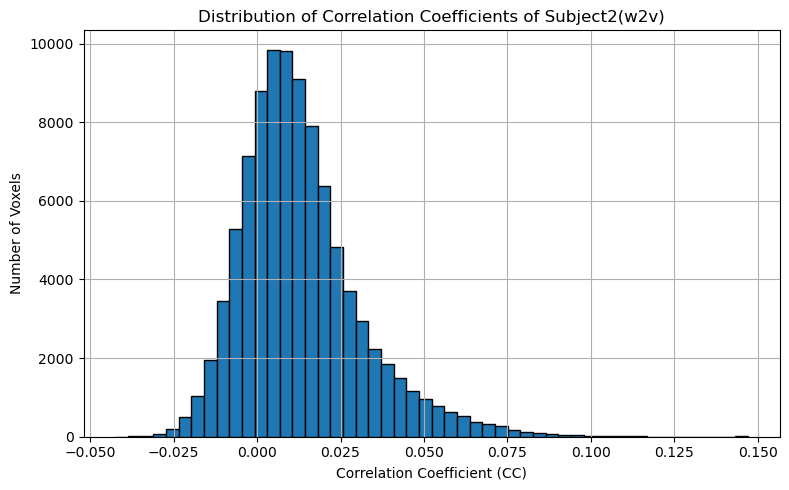

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(w2v)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_w2v_2.png", dpi=300)
plt.tight_layout()
plt.show()

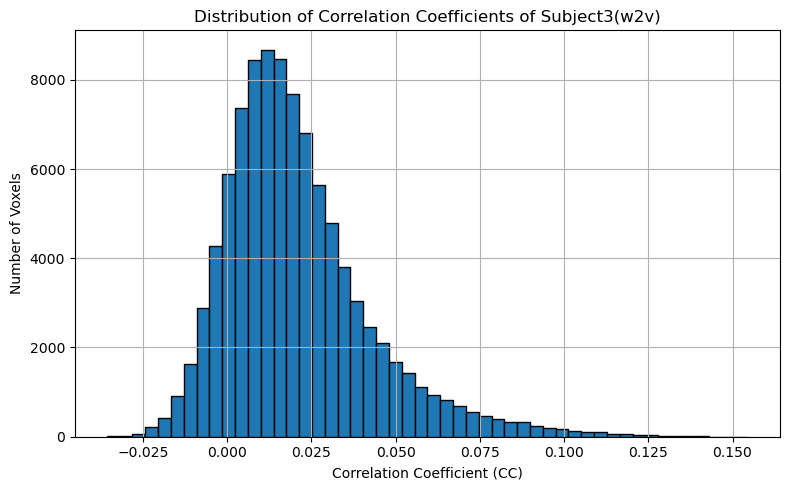

In [29]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(w2v)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_w2v_3.png", dpi=300)
plt.tight_layout()
plt.show()

<h1>stability check<h1>

To perform a stability check, we reshuffle the stories and generate a new train/test split, and compare model performance across different test stories

In [30]:
path_to_data = '/ocean/projects/mth240012p/shared/data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)
random.seed(214)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

train_stories.sort()
test_stories.sort()

allwords = []
for story in train_stories:
    temp_text = raw_text[story].data
    allwords += temp_text

print(len(allwords))

#compute unique words in train_stories
unique_words = list(set(allwords))
len(unique_words)

130443


9964

In [31]:
model_path = '../data/GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(model_path, binary=True)
in_model = [word for word in unique_words if word in w2v]
not_in_model = [word for word in unique_words if word not in w2v]
print(f"Percentage of words Not in w2v model: {len(not_in_model)/len(unique_words):.4f}")

for story in train_stories:
    words = raw_text[story].data
    story_vectors_w2v[story] = embed_story_words(words, w2v, vector_size)

# downsample and trim matrix
wordseqs = {story: raw_text[story] for story in train_stories}
# we already defines wordseqs in BoW method.
downsampled_vectors_2 = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_w2v,
    wordseqs=wordseqs
)

trimmed_vectors_2 = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_2.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_2[story] = trimmed_matrix
    
# create lagged version of matrices
delayed_vectors_2 = {}

for story, trimmed_matrix in trimmed_vectors_2.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_2[story] = X_lagged

# check for first trimmed,delayed matrix, which corresponds to first story
for key, value in delayed_vectors_2.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break


story_vectors_w2v_test = {}
for story in test_stories:
    words = raw_text[story].data
    story_vectors_w2v_test[story] = embed_story_words(words, w2v, vector_size)

wordseqs2 = {story: raw_text[story] for story in test_stories}
downsampled_vectors_2_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_w2v_test,
    wordseqs=wordseqs2
)

trimmed_vectors_2_test = {} #trimmed matrices for each test story 
for story, matrix in downsampled_vectors_2_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_2_test[story] = trimmed_matrix

delayed_vectors_2_test = {}
for story, trimmed_matrix in trimmed_vectors_2_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_2_test[story] = X_lagged

INFO:gensim.models.keyedvectors:loading projection weights from ../data/GoogleNews-vectors-negative300.bin
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from ../data/GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-04-11T22:33:45.121676', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:27:36) [GCC 11.2.0]', 'platform': 'Linux-4.18.0-553.36.1.el8_10.x86_64-x86_64-with-glibc2.28', 'event': 'load_word2vec_format'}


Percentage of words Not in w2v model: 0.0560
First key: adollshouse
delayed matrix for first story is (241, 1200)


In [32]:
import gc
del w2v
del raw_text
gc.collect()

0

In [33]:
# subject 2

path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

#Test for w2v, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_2[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_2_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1401.970
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.004196347231061547


In [34]:
# cross validation
random.seed(214)
np.random.seed(214)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=214)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_2[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_2[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19340, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1250.555
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00381, max corr=0.09999, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00395, max corr=0.10198, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00443, max corr=0.10738, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00564, max corr=0.11581, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00769, max corr=0.12076, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00927, max corr=0.12801, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00926, max corr=0.12412, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00875, max corr=0.11324, over-und

Processing fold 2/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18892, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1241.617
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00520, max corr=0.10364, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00536, max corr=0.10606, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00592, max corr=0.11367, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00743, max corr=0.12661, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00983, max corr=0.12969, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01164, max corr=0.11891, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01188, max corr=0.12145, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01146, max corr=0.11867, over-und

Processing fold 3/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18921, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1244.224
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00422, max corr=0.09572, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00447, max corr=0.09831, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00528, max corr=0.10602, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00724, max corr=0.11946, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01027, max corr=0.13142, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01213, max corr=0.13612, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01177, max corr=0.13060, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01090, max corr=0.12180, over-und

Processing fold 4/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19373, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1278.721
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00463, max corr=0.10642, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00493, max corr=0.10830, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00595, max corr=0.11312, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00827, max corr=0.12954, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01149, max corr=0.14837, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01387, max corr=0.14337, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01392, max corr=0.13352, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01306, max corr=0.13006, over-und

Processing fold 5/5 for w2v


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18766, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1254.860
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00465, max corr=0.13085, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00491, max corr=0.13149, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00577, max corr=0.13430, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00769, max corr=0.14357, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01052, max corr=0.15665, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01269, max corr=0.15133, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01297, max corr=0.13768, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01249, max corr=0.13013, over-und

In [35]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (w2v): {mean_cc_s2}")
print(f"Median test CC for subject 2 (w2v): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (w2v): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (w2v): {top_5_percentile_cc_s2}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1401.970
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (w2v): 0.01135738090877661
Median test CC for subject 2 (w2v): 0.009256884273539734
Top 1 percentile test CC for subject 2 (w2v): 0.05987404689523712
Top 5 percentile test CC for subject 2 (w2v): 0.04098098387945782


In [36]:
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

231

In [37]:
# subject 3
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

num_vox_s3 = 95556
corr_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas= np.ones(num_vox_s3))
mean_cc_3 = np.mean(corr_s3[np.isfinite(corr_s3)]) #exclude
print("Mean CC for sub3:", mean_cc_3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1401.970
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean CC for sub3: 0.007509795373726774


In [38]:
# cross validation
random.seed(214)
np.random.seed(214)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=214)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_2[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_2[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19340, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1250.555
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01097, max corr=0.13967, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01127, max corr=0.14040, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01229, max corr=0.14256, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01485, max corr=0.15001, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01892, max corr=0.16077, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02143, max corr=0.15652, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02060, max corr=0.15215, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01912, max corr=0.14723, over-und

Processing fold 2/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18892, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1241.617
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00753, max corr=0.13562, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00786, max corr=0.13860, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00898, max corr=0.14738, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01175, max corr=0.16270, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01588, max corr=0.17266, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01863, max corr=0.17223, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01842, max corr=0.14834, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01738, max corr=0.14076, over-und

Processing fold 3/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18921, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1244.224
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00961, max corr=0.13922, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00995, max corr=0.14188, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01105, max corr=0.14969, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01352, max corr=0.16400, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01739, max corr=0.17862, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02022, max corr=0.17114, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02016, max corr=0.15538, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01909, max corr=0.15169, over-und

Processing fold 4/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19373, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1278.721
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00987, max corr=0.13821, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01025, max corr=0.14218, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01152, max corr=0.15370, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01434, max corr=0.17000, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01835, max corr=0.18605, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02120, max corr=0.17897, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02123, max corr=0.16579, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02023, max corr=0.15752, over-und

Processing fold 5/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18766, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1254.860
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01103, max corr=0.13364, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01146, max corr=0.13583, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01285, max corr=0.14820, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01592, max corr=0.16719, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01993, max corr=0.17860, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02147, max corr=0.16564, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02003, max corr=0.15666, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01862, max corr=0.15534, over-und

In [39]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (w2v): {mean_cc_s3}")
print(f"Median test CC for subject 3 (w2v): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (w2v): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (w2v): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1401.970
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 3 (w2v): 0.020049033525352575
Median test CC for subject 3 (w2v): 0.016161196954413776
Top 1 percentile test CC for subject 3 (w2v): 0.08895038866821053
Top 5 percentile test CC for subject 3 (w2v): 0.06093207693453907


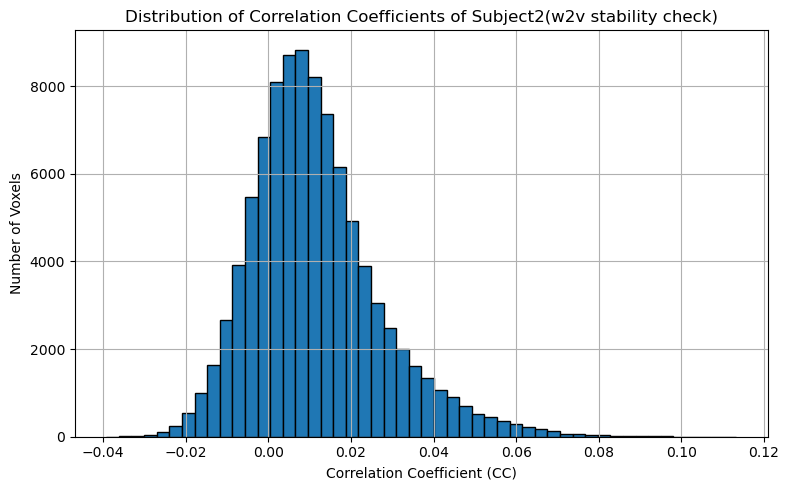

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(w2v stability check)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_w2v_stability2.png", dpi=300)
plt.tight_layout()
plt.show()

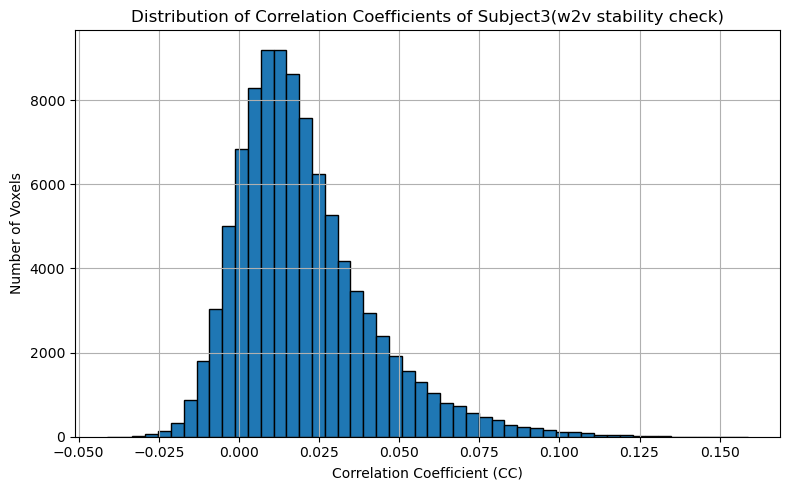

In [41]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(w2v stability check)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_w2v_stability3.png", dpi=300)
plt.tight_layout()
plt.show()